In [113]:
import os
import re
import random
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from scripts.data_cleaning import clean_data

In [114]:
import warnings
warnings.filterwarnings('ignore')

In [115]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [116]:
# clean data 
train.set_index("id", inplace=True)
test.set_index("id", inplace=True)
cleaned_train = clean_data(train)
cleaned_test = clean_data(test)

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    """ref :https://www.kaggle.com/code/ryanholbrook/mutual-information

    """
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, n_neighbors=5)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [183]:
cleaned_train = pd.concat( [cleaned_train[cleaned_train['prod_taken']==1], cleaned_train.sample(500) ])

In [184]:
# cleaned_train

In [185]:
CAT_COL  = cleaned_test.select_dtypes(include=['object', 'category']).columns
NUM_COL = [col for col in X.columns if col not in CAT_COL]
CONT_COL = ["age", "duration_of_pitch", "monthly_income"]

In [186]:
# outlier_detection
def outlier_analysis(X_in, col):
    print("column ", col)
    X = X_in[X_in["prod_taken"]==1]
    q1 = X[col].quantile(0.25)
    q3 = X[col].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    med = np.median(X[col])
    drop_index = X[(X[col] > Upper_tail) | (X[col] < Lower_tail)].index
    

    print('lower limit: {} | upper limit: {}'.format(Lower_tail, Upper_tail))
    print('iqr: {}'.format(iqr))
    print("len of outlier", len(drop_index))
    print("="*44)
    
    return X_in.drop(drop_index)

def impute(X):
    X = X.copy()
    X[NUM_COL] = X[NUM_COL].fillna(X[NUM_COL].median())
    for col in NUM_COL:
        if col not in CONT_COL:
            X[col] = X[col].astype('int')
    X[CAT_COL] = X[CAT_COL].fillna("unknown")
    return X

In [187]:
# y = cleaned_train['prod_taken']
# X = cleaned_train.drop(columns=["prod_taken"], axis=1)
X = cleaned_train.copy()

In [188]:
# NUM_COL.pop(-1)

In [189]:
for col in CONT_COL+["number_of_followups"]:
    X = outlier_analysis(X, col)

column  age
lower limit: 2.0 | upper limit: 66.0
iqr: 16.0
len of outlier 17
column  duration_of_pitch
lower limit: -90.0 | upper limit: 1590.0
iqr: 420.0
len of outlier 33
column  monthly_income
lower limit: 132637.5 | upper limit: 475417.5
iqr: 85695.0
len of outlier 45
column  number_of_followups
lower limit: 1.5 | upper limit: 5.5
iqr: 1.0
len of outlier 40


In [190]:
# X

In [191]:
X = impute(X)

In [192]:
# X.isna().sum()

In [193]:
# for colname in X.columns:
#     if X[colname].dtype!= "object":
#         X[colname]= X[colname].fillna(X[colname].median())
    
# for colname in X.select_dtypes("object"):
#     X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
# discrete_features = X.dtypes == int

In [194]:
y = X['prod_taken']
X = X.drop(columns=["prod_taken"], axis=1)

In [195]:
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [196]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  #

product_pitched             0.120289
age                         0.048678
pitch_satisfaction_score    0.034571
marital_status              0.020620
gender                      0.003852
number_of_trips             0.000000
Name: MI Scores, dtype: float64

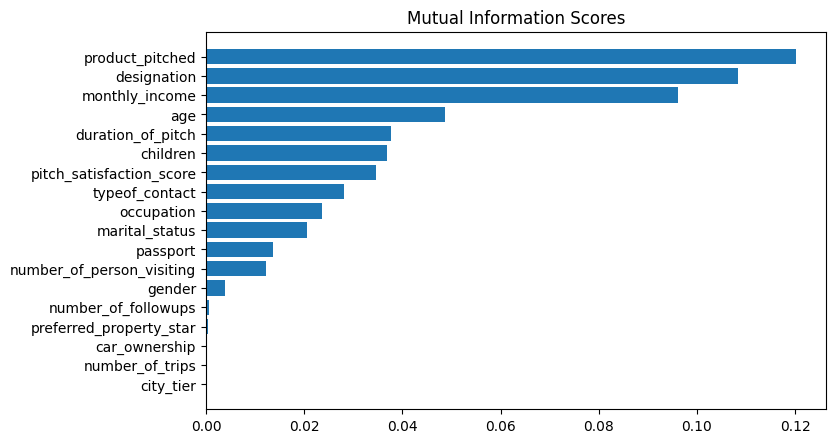

In [197]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [134]:
# X

In [135]:
mi_scores[:14].index

Index(['product_pitched', 'designation', 'monthly_income', 'duration_of_pitch',
       'age', 'number_of_followups', 'passport', 'pitch_satisfaction_score',
       'typeof_contact', 'marital_status', 'occupation', 'gender',
       'number_of_person_visiting', 'children'],
      dtype='object')

In [179]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)

In [180]:
selected_top_columns.fit(X, y)

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_regression at 0x7f74b04ee6a8>)

In [181]:
X.columns[selected_top_columns.get_support()]

Index(['duration_of_pitch', 'product_pitched', 'designation',
       'monthly_income'],
      dtype='object')

In [175]:
import numpy as np
from scipy.stats import rankdata, norm


def xicor(x, y, ties="auto"):
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    n = len(y)

    if len(x) != n:
        raise IndexError(
            f"x, y length mismatch: {len(x)}, {len(y)}"
        )

    if ties == "auto":
        ties = len(np.unique(y)) < n
    elif not isinstance(ties, bool):
        raise ValueError(
            f"expected ties either \"auto\" or boolean, "
            f"got {ties} ({type(ties)}) instead"
        )
    
    y = y[np.argsort(x)]
    r = rankdata(y, method="ordinal")
    nominator = np.sum(np.abs(np.diff(r)))

    if ties:
        l = rankdata(y, method="max")
        denominator = 2 * np.sum(l * (n - l))
        nominator *= n
    else:
        denominator = np.power(n, 2) - 1
        nominator *= 3

    statistic = 1 - nominator / denominator  # upper bound is (n - 2) / (n + 1)
    p_value = norm.sf(statistic, scale=2 / 5 / np.sqrt(n))

    return statistic, round(p_value, 6)

In [176]:
s_val = []
p_val = []
for col in X.columns:
    s, p = xicor(X[col], y)
    s_val.append(s)
    p_val.append(p)
    
xicor_df = pd.DataFrame({"corr": s_val, "pvalue": p_val}, index=X.columns)

In [177]:
xicor_df.sort_values("corr", ascending=False)

,corr,pvalue
passport,0.802155,0.00000
car_ownership,0.722505,0.00000
preferred_property_star,0.556703,0.00000
gender,0.501102,0.00000
typeof_contact,0.471991,0.00000
product_pitched,0.452407,0.00000
number_of_person_visiting,0.448288,0.00000
city_tier,0.434398,0.00000
number_of_followups,0.390504,0.00000
occupation,0.389373,0.00000


<AxesSubplot:>

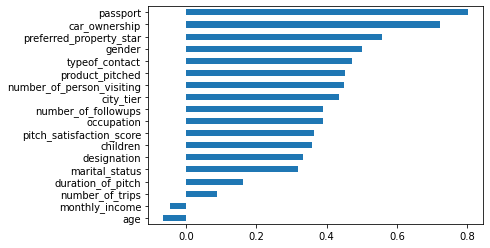

In [155]:
xicor_df["corr"].sort_values().plot(kind="barh")

In [159]:
s_val = []
p_val = []
cols1 = []
cols2 = []
rev_sval = []
rev_pval = []
from itertools import combinations
for col1, col2 in combinations(X.columns, 2):

    cols1.append(col1)
    cols2.append(col2)
    
    s, p = xicor(X[col1], X[col2])
    s_val.append(s)
    p_val.append(p)
    
    
    s, p = xicor(X[col2], X[col1])
    rev_sval.append(s)
    rev_pval.append(p)
# print(len(s_val), len(p_val), len(cols1), len(cols2))
xicor_df_mutual = pd.DataFrame({"corr": s_val,  "rev_corr":rev_sval, "column1": cols1, "column2": cols2})

In [178]:
xicor_df_mutual.sort_values("column1", ascending=False)

,corr,rev_corr,column1,column2
28,0.288248,0.172768,typeof_contact,designation
17,0.110175,0.221350,typeof_contact,city_tier
32,0.139795,0.142695,typeof_contact,children
31,0.426516,0.213121,typeof_contact,car_ownership
30,0.016705,0.154824,typeof_contact,marital_status
...,...,...,...,...
12,0.468960,0.138895,age,designation
13,0.128018,0.224150,age,monthly_income
14,0.022316,0.012308,age,marital_status
15,0.464348,0.059205,age,car_ownership


In [168]:
X.groupby("designation")["product_pitched"].value_counts()

designation  product_pitched
0            0                  479
             3                    4
             1                    1
             2                    1
1            1                  177
             0                    1
             3                    1
             4                    1
2            2                  169
             0                    6
             3                    4
             1                    1
3            3                   48
             0                    2
             4                    1
4            4                   12
             3                    2
             1                    1
Name: product_pitched, dtype: int64

In [169]:
cleaned_train.groupby("designation")["product_pitched"].value_counts()

designation     product_pitched
avp             super deluxe        62
                basic                2
                king                 2
executive       basic              521
                super deluxe         6
                deluxe               1
                standard             1
manager         deluxe             171
                basic                6
                super deluxe         4
                standard             1
senior manager  standard           195
                basic                1
                king                 1
                super deluxe         1
vp              king                17
                super deluxe         4
                standard             1
Name: product_pitched, dtype: int64

In [174]:
cleaned_train.groupby("car_ownership")["prod_taken"].mean()

car_ownership
Car Ownership       0.570125
No Car Ownership    0.583333
Name: prod_taken, dtype: float64

## general overview

In [5]:
train.shape, test.shape

((3489, 17), (3489, 16))

In [6]:
train.head().T

id,0,1,2,3,4
Age,50歳,56歳,NaN,三十七歳,48歳
TypeofContact,Self Enquiry,Company Invited,Self Enquiry,Self Enquiry,Company Invited
CityTier,2,1,1,2,3
DurationOfPitch,900秒,14分,10分,1080秒,1020秒
Occupation,Large Business,Salaried,Large Business,Small Business,Small Business
Gender,male,Male,Female,female,female
NumberOfPersonVisiting,1,1,1,1,1
NumberOfFollowups,4,4,3,3,3
ProductPitched,Basic,Standard,Basic,Standard,Basic
PreferredPropertyStar,3,3,3,4,4


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3389 non-null   object 
 1   TypeofContact           3483 non-null   object 
 2   CityTier                3489 non-null   int64  
 3   DurationOfPitch         3368 non-null   object 
 4   Occupation              3489 non-null   object 
 5   Gender                  3489 non-null   object 
 6   NumberOfPersonVisiting  3489 non-null   float64
 7   NumberOfFollowups       3456 non-null   float64
 8   ProductPitched          3489 non-null   object 
 9   PreferredPropertyStar   3489 non-null   float64
 10  NumberOfTrips           3467 non-null   object 
 11  Passport                3489 non-null   int64  
 12  PitchSatisfactionScore  3489 non-null   int64  
 13  Designation             3489 non-null   object 
 14  MonthlyIncome           3433 non-null   

In [8]:
cleaned_train.columns

Index(['age', 'typeof_contact', 'city_tier', 'duration_of_pitch', 'occupation',
       'gender', 'number_of_person_visiting', 'number_of_followups',
       'product_pitched', 'preferred_property_star', 'number_of_trips',
       'passport', 'pitch_satisfaction_score', 'designation', 'monthly_income',
       'prod_taken', 'marital_status', 'car_ownership', 'children'],
      dtype='object')

In [9]:
cleaned_train["prod_taken"].value_counts()*100/len(cleaned_train)

0    85.755231
1    14.244769
Name: prod_taken, dtype: float64

In [42]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(cleaned_train,  alpha=0.2, figsize=(10, 10))

(0.0, 12.0)

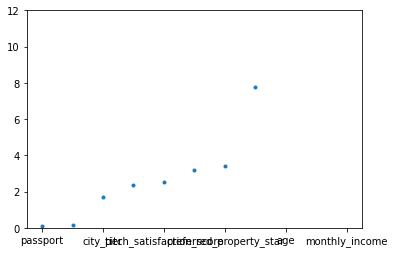

In [52]:
means = cleaned_train.mean()

# Sort the columns based on their means
sorted_columns = means.sort_values().index

# Reorder the DataFrame columns
df_sorted = cleaned_train[sorted_columns]
ax = df_sorted.mean().plot(style=".")
ax.set_ylim(0,12)

In [10]:
def check_nan_count(col_before, col_after):
    # city tier
    print("train", train[col_before].isna().sum() == cleaned_train[col_after].isna().sum())
    print("test", test[col_before].isna().sum() == cleaned_test[col_after].isna().sum())

In [11]:
def plot_hist(col, bins=10):
    cleaned_train[col].plot(kind="hist", alpha=0.5,bins=bins)
    cleaned_test[col].plot(kind="hist", alpha=0.5, bins=bins)

## column: id 

In [12]:
# train["id"].nunique(), test["id"].nunique()

In [13]:
# train["id"].min(), train["id"].max(), test["id"].min(), test["id"].max()

### just id of the row

## column: age 

In [14]:
cleaned_train["age"].nunique(), cleaned_test["age"].nunique()

(53, 53)

In [15]:
cleaned_train["age"].describe()

count    3389.000000
mean       40.549425
std        13.839600
min        10.000000
25%        31.000000
50%        39.000000
75%        48.000000
max       140.000000
Name: age, dtype: float64

In [16]:
cleaned_test["age"].describe()

count    3396.000000
mean       40.635748
std        14.221480
min        10.000000
25%        31.000000
50%        39.000000
75%        48.000000
max       140.000000
Name: age, dtype: float64

### minimum of age is 10 and maximum is 140, which is little odd

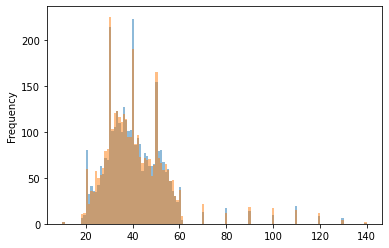

In [17]:
plot_hist("age", 131)

In [18]:
#looks like some of the ages are missing, let's find out the missing age
age_range = [10, 140]
missing_ages = []

for age in range(10, 140): 
    if age not in cleaned_train["age"].unique() and age not in cleaned_test["age"].unique():
        missing_ages.append(age)

In [19]:
missing_ages = sorted(missing_ages)

In [20]:
len(missing_ages)

78

In [56]:
# missing_ages

In [21]:
# it could be possible that some of the age values are altered?
# slice the df based on age 
age_common = cleaned_train[(cleaned_train.age>=18) | (cleaned_train.age<=61)]
age_outliar = cleaned_train[(cleaned_train.age<18) | (cleaned_train.age> 61)]

In [22]:
age_common["prod_taken"].value_counts()*100/len(age_common)

0    86.161109
1    13.838891
Name: prod_taken, dtype: float64

In [23]:
age_outliar["prod_taken"].value_counts()

0    79
1    11
Name: prod_taken, dtype: int64

In [24]:
age_outliar["prod_taken"].value_counts()*100/len(age_outliar)

0    87.777778
1    12.222222
Name: prod_taken, dtype: float64

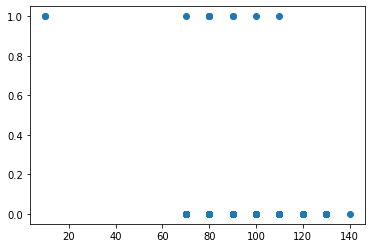

In [25]:
plt.scatter(age_outliar["age"], age_outliar["prod_taken"])

In [26]:
age_outliar[["age", "marital_status", "children"]].sort_values("age")

,age,marital_status,children
id,,,
723,10.0,Unmarried,2 Children
1695,10.0,Single,NaN
622,70.0,Unmarried,2 Children
2550,70.0,Single,1 Children
797,70.0,Divorced,NaN
...,...,...,...
448,130.0,Married,1 Children
1244,130.0,Single,1 Children
3407,130.0,Married,1 Children


## 10 years old with children, there seems to be issues with the data

## columns: TypeofContact

In [27]:
check_nan_count("TypeofContact", "typeof_contact")

train True
test True


In [28]:
cleaned_train["typeof_contact"].value_counts(dropna=False)

Self Enquiry       2194
Company Invited    1289
NaN                   6
Name: typeof_contact, dtype: int64

In [29]:
cleaned_test["typeof_contact"].value_counts(dropna=False)

Self Enquiry       2250
Company Invited    1227
NaN                  12
Name: typeof_contact, dtype: int64

In [30]:
cleaned_train.groupby("typeof_contact")["prod_taken"].mean()

typeof_contact
Company Invited    0.182312
Self Enquiry       0.119417
Name: prod_taken, dtype: float64

In [31]:
cleaned_train.groupby(["typeof_contact", "designation"])["prod_taken"].mean()

typeof_contact   designation   
Company Invited  avp               0.083333
                 executive         0.395294
                 manager           0.051680
                 senior manager    0.100575
                 vp                0.142857
Self Enquiry     avp               0.073892
                 executive         0.257261
                 manager           0.027108
                 senior manager    0.077075
                 vp                0.040816
Name: prod_taken, dtype: float64

## city tier

In [32]:
# city tier
check_nan_count("CityTier", "city_tier")


train True
test True


In [33]:
cleaned_train["city_tier"].value_counts(dropna=False)

2    1596
1    1475
3     418
Name: city_tier, dtype: int64

In [34]:
cleaned_test["city_tier"].value_counts(dropna=False)

2    1564
1    1516
3     409
Name: city_tier, dtype: int64

## columns: duration of pitch 

In [35]:
check_nan_count("DurationOfPitch", "duration_of_pitch")

train True
test True


In [36]:
cleaned_train["duration_of_pitch"].value_counts(dropna=False)

480.0     338
540.0     327
900.0     284
840.0     266
960.0     259
420.0     239
600.0     231
780.0     203
660.0     160
720.0     158
1020.0    136
NaN       121
360.0      80
1080.0     74
1920.0     53
1380.0     51
1320.0     45
1860.0     43
1440.0     40
1500.0     38
1200.0     36
1620.0     35
1980.0     34
1260.0     31
1800.0     31
1680.0     29
2040.0     29
1560.0     27
2100.0     25
1740.0     20
1140.0     19
300.0      18
2160.0      7
240.0       2
Name: duration_of_pitch, dtype: int64

In [37]:
cleaned_test["duration_of_pitch"].value_counts(dropna=False)

480.0     333
540.0     327
900.0     285
960.0     268
840.0     252
600.0     236
420.0     207
780.0     194
1020.0    176
660.0     146
720.0     135
NaN       131
360.0      87
1080.0     59
1380.0     53
2040.0     46
1440.0     46
1860.0     43
1500.0     41
1920.0     40
1320.0     39
1560.0     37
1980.0     35
1800.0     34
1260.0     34
2100.0     33
1140.0     31
1200.0     30
1740.0     28
1680.0     27
300.0      25
1620.0     22
2160.0      8
240.0       1
Name: duration_of_pitch, dtype: int64

In [38]:
# all the numbers are divisible by 60! why?

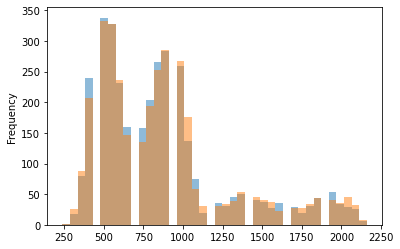

In [39]:
plot_hist("duration_of_pitch", 40)

In [40]:
# does pitch has any relation with contact type?

In [41]:
cleaned_train.groupby("typeof_contact")["duration_of_pitch"].mean()

typeof_contact
Company Invited    874.165982
Self Enquiry       852.982783
Name: duration_of_pitch, dtype: float64

In [42]:
cleaned_train.groupby("product_pitched")["duration_of_pitch"].mean()

product_pitched
basic            801.095406
deluxe          1045.263158
king             723.809524
standard         729.274673
super deluxe     922.946708
Name: duration_of_pitch, dtype: float64

In [43]:
cleaned_train.groupby("gender")["duration_of_pitch"].mean()

gender
female    873.796635
male      851.724138
Name: duration_of_pitch, dtype: float64

In [44]:
cleaned_train.groupby("prod_taken")["duration_of_pitch"].mean()

prod_taken
0    866.114958
1    828.000000
Name: duration_of_pitch, dtype: float64

In [45]:
cleaned_train[cleaned_train["duration_of_pitch"].isna()]["prod_taken"].value_counts()

0    104
1     17
Name: prod_taken, dtype: int64

In [46]:
cleaned_train[cleaned_train["duration_of_pitch"].isna()]["product_pitched"].value_counts()

deluxe          95
basic           25
super deluxe     1
Name: product_pitched, dtype: int64

In [47]:
check_nan_count("Gender", "gender")

train True
test True


In [48]:
cleaned_train["gender"].value_counts(dropna=False)

male      2064
female    1425
Name: gender, dtype: int64

In [49]:
cleaned_test["gender"].value_counts(dropna=False)

male      2154
female    1335
Name: gender, dtype: int64

In [50]:
cleaned_train.groupby("gender")["prod_taken"].mean()

gender
female    0.102456
male      0.170058
Name: prod_taken, dtype: float64

In [51]:
cleaned_train.groupby("gender")["monthly_income"].mean()

gender
female    350196.522206
male      359423.399607
Name: monthly_income, dtype: float64

In [52]:
cleaned_train["marital_status"].value_counts(dropna=False)

Married      1384
Divorced      878
Single        646
Unmarried     581
Name: marital_status, dtype: int64

In [53]:
cleaned_train["children"].value_counts(dropna=False)

1 Children     1531
No Children     985
2 Children      807
3 Children       72
NaN              57
unknown          37
Name: children, dtype: int64

In [54]:
cleaned_train["car_ownership"].value_counts(dropna=False)

Car Ownership       3069
No Car Ownership     420
Name: car_ownership, dtype: int64

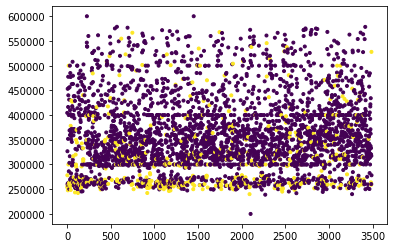

In [37]:
plt.scatter(range(len(train)), cleaned_train["monthly_income"],marker=".", c=y)

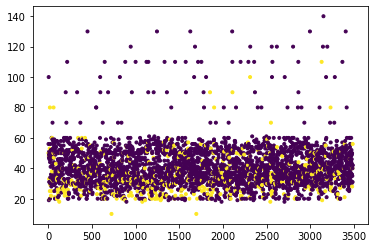

In [38]:
plt.scatter(range(len(train)), cleaned_train["age"],marker=".", c=y)